In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

In [52]:
#Visualizations

# Specify the path to your CSV file
file_path = "shrunk_output.csv"

# Convert the CSV file to a DataFrame
df = pd.read_csv(file_path)
# Display the first few rows of the DataFrame
print(df)


         searchDate  flightDate startingAirport destinationAirport  \
0        2022-08-26  2022-08-30             ATL                LAX   
1        2022-09-27  2022-10-08             SFO                EWR   
2        2022-06-29  2022-08-04             OAK                SFO   
3        2022-05-26  2022-06-24             EWR                DEN   
4        2022-04-17  2022-06-05             LAX                PHL   
...             ...         ...             ...                ...   
1642770  2022-06-19  2022-06-23             PHL                CLT   
1642771  2022-08-18  2022-08-19             PHL                JFK   
1642772  2022-07-05  2022-08-22             LAX                JFK   
1642773  2022-09-22  2022-09-23             JFK                MIA   
1642774  2022-04-20  2022-05-24             OAK                LAX   

         isBasicEconomy  isNonStop  baseFare  totalFare  
0                 False      False    305.12     350.10  
1                 False      False    385.1

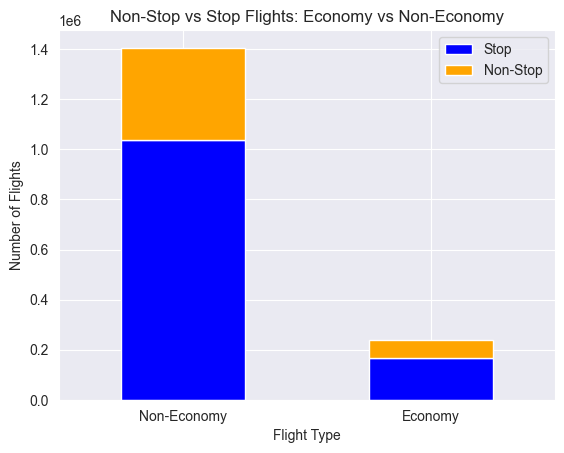

In [15]:
non_stop_counts = df.groupby(['isBasicEconomy', 'isNonStop']).size().unstack()

non_stop_counts.plot(kind='bar', stacked=True, color=['blue', 'orange'])
plt.title('Non-Stop vs Stop Flights: Economy vs Non-Economy')
plt.xticks(ticks=[0, 1], labels=['Non-Economy', 'Economy'], rotation=0)
plt.xlabel('Flight Type')
plt.ylabel('Number of Flights')
plt.legend(['Stop', 'Non-Stop'])
plt.show()


/var/folders/7q/7kvrhgd96yxftk3nv72_klcr0000gn/T/ipykernel_20771/1966411390.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='isBasicEconomy', y='totalFare', palette='coolwarm')


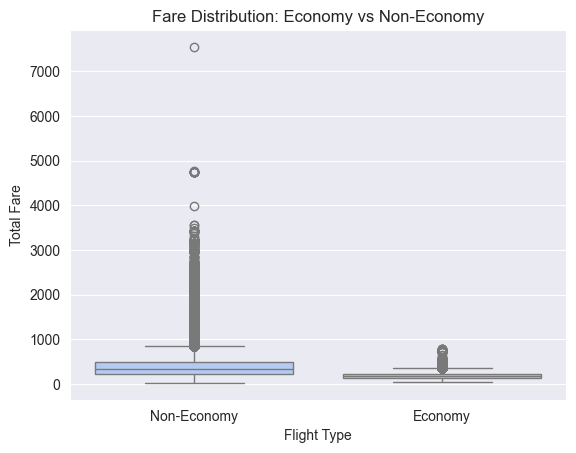

In [16]:
sns.boxplot(data=df, x='isBasicEconomy', y='totalFare', palette='coolwarm')
plt.xticks(ticks=[0, 1], labels=['Non-Economy', 'Economy'])
plt.title('Fare Distribution: Economy vs Non-Economy')
plt.xlabel('Flight Type')
plt.ylabel('Total Fare')
plt.show()

In [17]:
df['flightDate'] = pd.to_datetime(df['flightDate'])
avg_fare = df.groupby(['flightDate', 'isBasicEconomy'])['totalFare'].mean().reset_index()

sns.lineplot(data=avg_fare, x='flightDate', y='totalFare', hue='isBasicEconomy', palette='Set1')
plt.title('Fare Trends Over Time: Economy vs Non-Economy')
plt.xlabel('Flight Date')
plt.ylabel('Average Total Fare')
plt.legend(['Non-Economy', 'Economy'])
plt.show()


KeyError: 'flightDate'

/var/folders/7q/7kvrhgd96yxftk3nv72_klcr0000gn/T/ipykernel_20771/1213232653.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=destination_counts.index, y=destination_counts.values, palette='viridis')


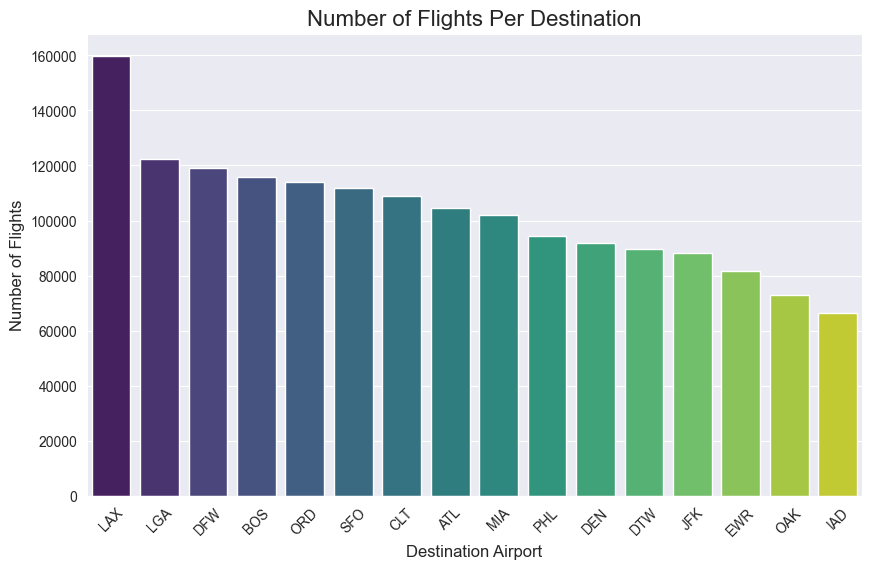

In [18]:
# Count the number of flights per destination
destination_counts = df['destinationAirport'].value_counts()

# Plot a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=destination_counts.index, y=destination_counts.values, palette='viridis')
plt.title('Number of Flights Per Destination', fontsize=16)
plt.xlabel('Destination Airport', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [19]:
# df = pd.get_dummies(df, columns=["startingAirport", "destinationAirport", "isBasicEconomy", "isNonStop"])
# 
# dummy_columns = df.filter(like="startingAirport_").columns.union(
#     df.filter(like="destinationAirport_").columns.union(
#         df.filter(like="isBasicEconomy_").columns.union(
#             df.filter(like="isNonStop_").columns
#         )
#     )
# )
# 
# df[dummy_columns] = df[dummy_columns].astype(int)


In [20]:
# df.head(5)

,baseFare,totalFare,startingAirport_ATL,startingAirport_BOS,startingAirport_CLT,startingAirport_DEN,startingAirport_DFW,startingAirport_DTW,startingAirport_EWR,startingAirport_IAD,...,destinationAirport_LGA,destinationAirport_MIA,destinationAirport_OAK,destinationAirport_ORD,destinationAirport_PHL,destinationAirport_SFO,isBasicEconomy_False,isBasicEconomy_True,isNonStop_False,isNonStop_True
0,305.12,350.10,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,385.12,437.60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,333.03,387.21,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
3,459.53,508.60,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4,730.23,808.60,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0


In [53]:
df = df[(df['isBasicEconomy'] == True)]

In [68]:
avg_price = df["totalFare"].mean()

df["searchDate"] = pd.to_datetime(df["searchDate"], errors="coerce")
df["flightDate"] = pd.to_datetime(df["flightDate"], errors="coerce")

df["dateDifference"] = (df["flightDate"] - df["searchDate"]).dt.days

avg_day_difference = df["dateDifference"].mean()

print(avg_price, avg_day_difference)
print(df)

178.9490167916359 28.53885309958813
       searchDate flightDate startingAirport destinationAirport  \
0      2022-04-29 2022-06-15             LGA                MIA   
1      2022-07-12 2022-08-24             EWR                LAX   
2      2022-09-02 2022-09-08             BOS                DEN   
3      2022-08-11 2022-08-18             LGA                ORD   
4      2022-09-13 2022-10-18             CLT                JFK   
...           ...        ...             ...                ...   
236720 2022-08-10 2022-09-10             IAD                MIA   
236721 2022-08-12 2022-09-17             LAX                DFW   
236722 2022-09-10 2022-09-23             LAX                EWR   
236723 2022-07-30 2022-09-12             JFK                PHL   
236724 2022-08-14 2022-08-30             CLT                SFO   

        isBasicEconomy  isNonStop  baseFare  totalFare priceLabel  \
0                 True       True     75.35      95.60       good   
1                 Tru

In [70]:
df["priceClassification"] = df.apply(lambda row: 0 if row['totalFare'] > avg_price * 1.05 or row['dateDifference'] > avg_day_difference * 1.1 else 1, axis=1)

print(df["priceClassification"].value_counts())

priceClassification
bad     159365
good     77360
Name: count, dtype: int64


In [ ]:
# Heuristic for Subtracting Dates
